In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline
from edfreader import read_edf
from aSPEM import aSPEM
import bayesianchangepoint as bcp


# the switching binomial generative model


In [2]:
t_titre = 35
t_label = 25
fig_width= 15

In [3]:
timeStr = '2017-09-20_151043'
observer = 'LB'
mode = 'enregistrement'

In [4]:
file = os.path.join('data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']

p = exp['p']
tau = N_trials/20.
h = 1/tau
seed = 51

## evaluating the best hazard rate using a likelihood score

In [6]:
N_scan = 100

hs = h*np.logspace(-1, 1, N_scan)
modes = ['expectation', 'max']
score = np.zeros((len(modes), N_scan, N_blocks))
for i_mode, mode in enumerate(modes):
    for i_block in range(N_blocks):
        o = p[:, i_block, 0]
        for i_scan, h_ in enumerate(hs):
            p_bar, r, beliefs = bcp.inference(o, h=h_, p0=.5)
            p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
            score[i_mode, i_scan, i_block] = np.mean(np.log2(1.e-12+bcp.likelihood(o, p_hat, r_hat)))

In [7]:
def plot_tous(p, score, pause=None, mode='expectation', max_run_length=150, fig_width=15, t_titre=35, t_label=25):
    
    for block in range(len(p[0][0])) :
        o = p[:, block, 0]
        p_true = p[:, block, 1]
        
        N_trials = o.size
        fig_width= fig_width
        fig, axs = plt.subplots(3, 1, figsize=(fig_width, (fig_width)/((1.6180*6)/2)))
        
        axs[0] = plt.subplot(221)
        axs[1] = plt.subplot(223)
        axs[2] = plt.subplot(143)
        plt.suptitle('Block %s'%(block), fontsize=t_label/2, y=1.05, x=0, ha='left')
        
        axs[0].step(range(N_trials), o, lw=1, alpha=.2, c='k')
        axs[0].step(range(N_trials), p_true, lw=1, alpha=.5, c='k')
        axs[0].fill_between(range(N_trials), np.zeros_like(o), o, lw=.5, alpha=.2, facecolor='k', step='pre')
        axs[0].fill_between(range(N_trials), np.zeros_like(p_true), p_true, lw=.5, alpha=.2, facecolor='k', step='pre')

        
        from scipy.stats import beta
        #---------------------------------------------------------------------------
        if pause is not None :
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=h, p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
                for i_trial in range(50):#N_trials):
                    p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])
                axs[0].plot(np.arange(liste[a], liste[a+1]), p_hat, c='r',  lw=1)
                axs[0].plot(np.arange(liste[a], liste[a+1]), p_sup, 'r--', lw=1)
                axs[0].plot(np.arange(liste[a], liste[a+1]), p_low, 'r--', lw=1)
                axs[0].fill_between(np.arange(liste[a], liste[a+1]), p_sup, p_low, lw=.5, alpha=.2, facecolor='r')
                
                axs[1].imshow(np.log(beliefs[:max_run_length, :]+ 1.e-5), cmap='Greys',
                              extent=(liste[a],liste[a+1], np.max(r), np.min(r)))
                
                axs[1].plot(np.arange(liste[a], liste[a+1]), r_hat, lw=1, alpha=.9, c='r')
            
            for a in range(2):
                axs[a].bar(50, 140 + 2*(.05*140), bottom=-.05*140, color='k', width=0, linewidth=2)
                axs[a].bar(100, 140 + 2*(.05*140), bottom=-.05*140, color='k', width=0, linewidth=2)
                axs[a].bar(150, 140 + 2*(.05*140), bottom=-.05*140, color='k', width=0, linewidth=2)
        else :
            p_bar, r, beliefs = bcp.inference(o, h=h, p0=.5)
            p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
            
            p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
            for i_trial in range(N_trials):
                p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])

            axs[0].plot(range(N_trials), p_hat, lw=1, alpha=.9, c='r')
            axs[0].plot(range(N_trials), p_sup, 'r--', lw=1, alpha=.9)
            axs[0].plot(range(N_trials), p_low, 'r--', lw=1, alpha=.9)
            axs[0].fill_between(range(N_trials), p_low, p_sup, lw=.5, alpha=.2, facecolor='r')
            
            axs[1].imshow(np.log(beliefs[:max_run_length, :] + 1.e-5 ), cmap='Greys')
            axs[1].plot(range(N_trials), r_hat, lw=1, alpha=.9, c='r')
        #---------------------------------------------------------------------------

        for i_layer, label in zip(range(2), ['$\hat{P}$ +/- CI', 'belief on r=p(r)']):
            axs[i_layer].set_xlim(0, N_trials)
            axs[i_layer].axis('tight')
            axs[i_layer].set_ylabel(label, fontsize=t_label/2)

        axs[1].set_ylim(-.05*140, 140 + (.05*140))
        axs[1].set_yticks(np.arange(0, 140 + (.05*140), 140/2))

        axs[1].set_xlabel('trials', fontsize=t_label/2);
        axs[0].set_ylim(-.05, 1 + .05)
        axs[0].set_yticks(np.arange(0, 1 + .05, 1/2))

        axs[1].set_xticks([-1, 49, 99,149])
        axs[1].set_xticklabels([0, 50, 100, 150], ha='left')
        axs[0].set_xticks([])
        axs[0].set_xticklabels([])
        if mode=='expectation' :
            i_mode = 0
        else :
            i_mode = 1

        axs[2].plot(hs, np.mean(score[i_mode, ...], axis=1), c='r', label=mode)
        axs[2].fill_between(hs,np.std(score[i_mode, ...], axis=1)+np.mean(score[i_mode, ...], axis=1), -np.std(score[i_mode, ...], axis=1)+np.mean(score[i_mode, ...], axis=1),  lw=.5, alpha=.2, facecolor='r', step='mid')

        axs[2].vlines(h, ymin=np.nanmin(score), ymax=np.nanmax(score), lw=2, label='true')
        axs[2].set_xscale("log")

        axs[2].set_xlabel('Hazard rate', fontsize=t_label/2)
        axs[2].set_ylabel('Mean log-likelihood (bits)', fontsize=t_label/2)
        axs[2].legend(frameon=False, loc="lower left")

        for i_layer in range(len(axs)) :      
            axs[i_layer].xaxis.set_ticks_position('bottom')
            axs[i_layer].yaxis.set_ticks_position('left')

        fig.tight_layout()
        plt.subplots_adjust(hspace=0.1)
        plt.show()
    return fig, axs

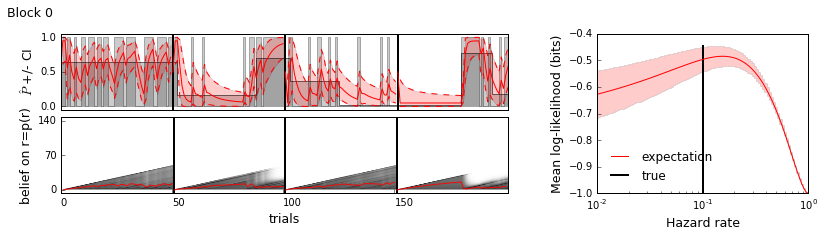

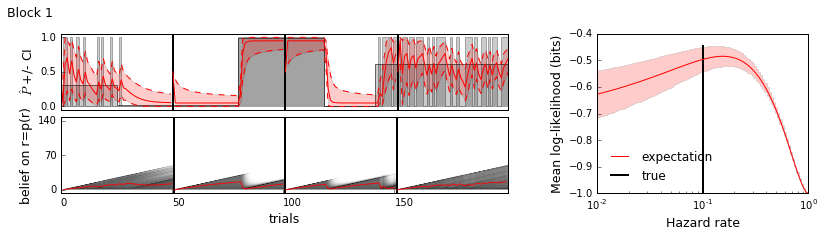

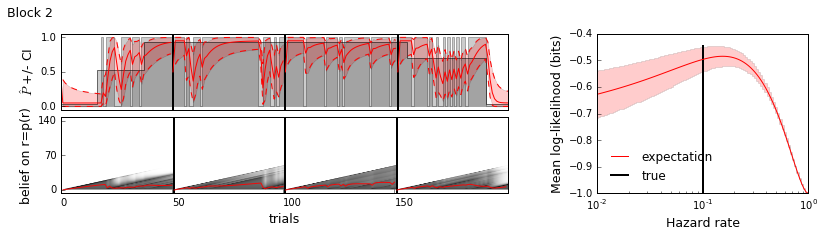

In [8]:
fig, axs = plot_tous(p, score, pause=True)

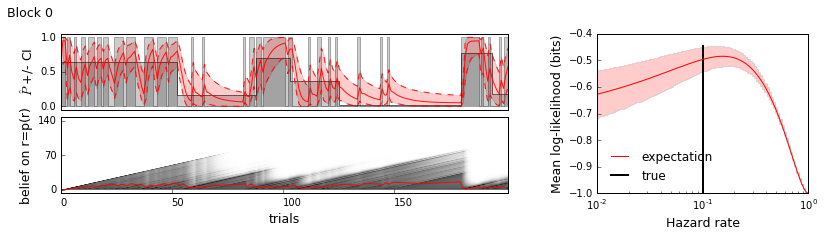

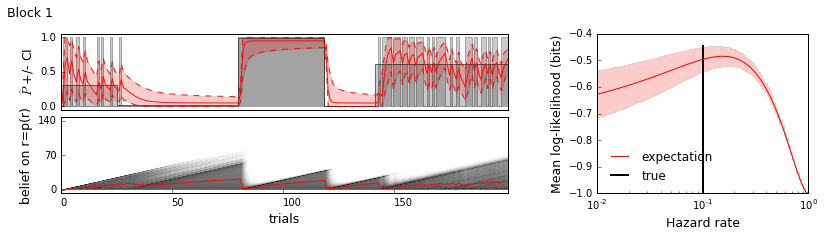

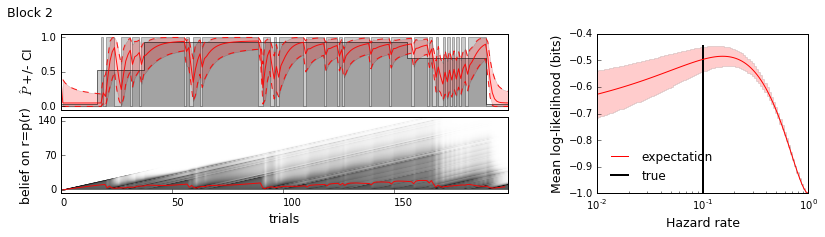

In [9]:
fig, axs = plot_tous(p, score)

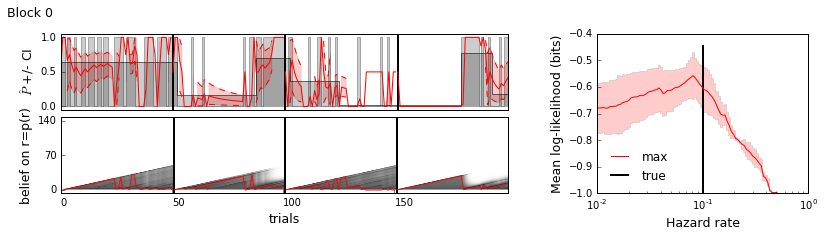

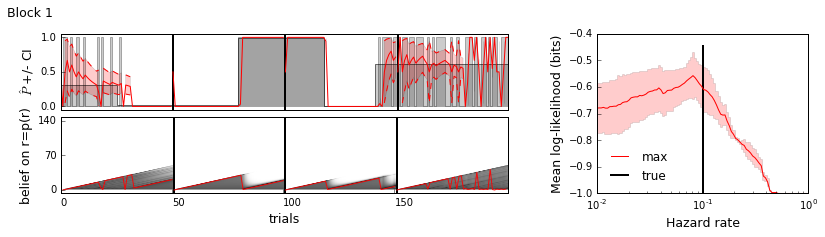

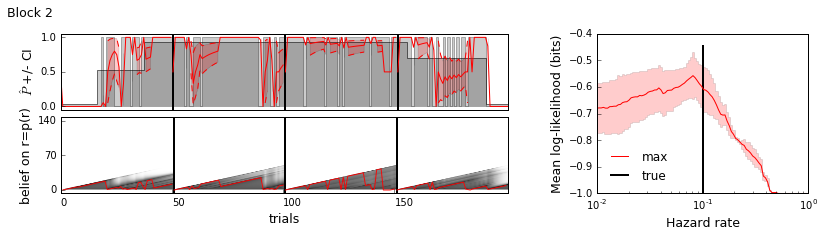

In [10]:
fig, axs = plot_tous(p, score, mode='max', pause=True)

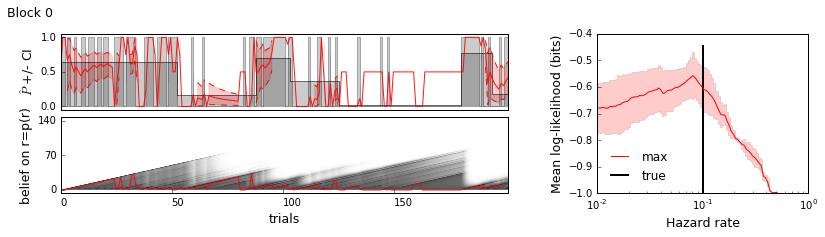

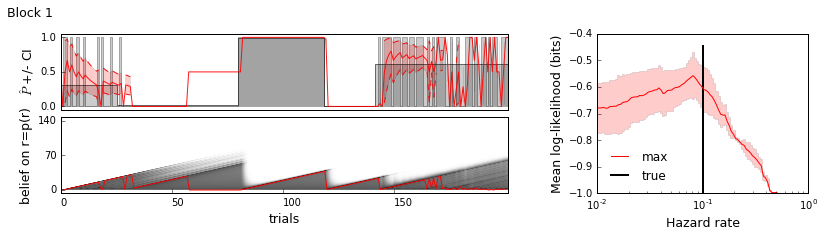

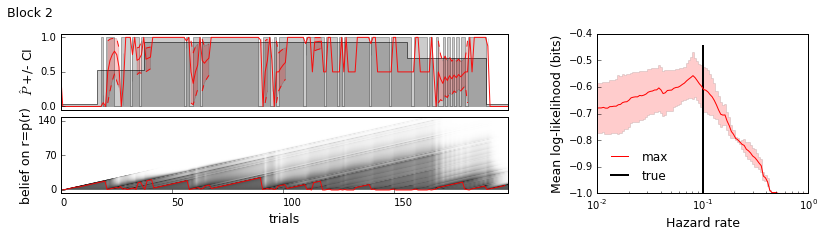

In [11]:
fig, axs = plot_tous(p, score, mode='max')

## Figure Poster

In [12]:
def fig(p, block, mode='expectation', max_run_length=150, fig_width=15, t_titre=35, t_label=25):
    block=block
    print('Block', block)
    o = p[:, block, 0]
    p_true = p[:, block, 1]

    N_trials = o.size
    fig_width= fig_width
    fig, axs = plt.subplots(2, 1, figsize=(fig_width, (fig_width)/((1.6180)*2)))

    axs[0] = plt.subplot(211)
    axs[1] = plt.subplot(212)
    

    axs[0].step(range(N_trials), o, lw=1, alpha=.2, c='k')
    axs[0].step(range(N_trials), p_true, lw=1, alpha=.5, c='k')
    axs[0].fill_between(range(N_trials), np.zeros_like(o), o, lw=.5, alpha=.2, facecolor='k', step='pre')
    axs[0].fill_between(range(N_trials), np.zeros_like(p_true), p_true, lw=.5, alpha=.2, facecolor='k', step='pre')


    from scipy.stats import beta

    p_bar, r, beliefs = bcp.inference(o, h=h, p0=.5)
    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)

    p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
    for i_trial in range(N_trials):
        p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])

    axs[0].plot(range(N_trials), p_hat, lw=1, alpha=.9, c='r')
    axs[0].plot(range(N_trials), p_sup, 'r--', lw=1, alpha=.9)
    axs[0].plot(range(N_trials), p_low, 'r--', lw=1, alpha=.9)
    axs[0].fill_between(range(N_trials), p_low, p_sup, lw=.5, alpha=.2, facecolor='r')

    axs[1].imshow(np.log(beliefs[:max_run_length, :] + 1.e-5 ), cmap='Greys')
    axs[1].plot(range(N_trials), r_hat, lw=1, alpha=.9, c='r')
    #---------------------------------------------------------------------------

    for i_layer, label in zip(range(2), ['$\hat{P}$ +/- CI', 'belief on \nr=p(r)']):
        axs[i_layer].set_xlim(0, N_trials)
        axs[i_layer].axis('tight')
        axs[i_layer].set_ylabel(label, fontsize=t_label/1.5)

        axs[i_layer].xaxis.set_ticks_position('bottom')
        axs[i_layer].yaxis.set_ticks_position('left')
        


    axs[1].set_ylim(-.05*140, 140 + (.05*140))
    axs[1].set_yticks(np.arange(0, 140 + (.05*140), 140/2))
    axs[1].yaxis.set_tick_params(labelsize=t_label/2)
    axs[1].set_xlabel('Trials', fontsize=t_label);
    
    axs[0].set_ylim(-.05, 1 + .05)
    axs[0].set_yticks(np.arange(0, 1 + .05, 1/2))
    axs[0].yaxis.set_tick_params(labelsize=t_label/2)
    
    axs[1].set_xticks([-1, 49, 99,149])
    axs[1].set_xticklabels([0, 50, 100, 150], ha='left', fontsize=t_label/2)
    axs[0].set_xticks([])
    axs[0].set_xticklabels([])


    if mode=='expectation' :
        i_mode = 0
    else :
        i_mode = 1

    for i_layer in range(len(axs)) :      
        axs[i_layer].xaxis.set_ticks_position('bottom')
        axs[i_layer].yaxis.set_ticks_position('left')

        
    axs[0].set_title('Bayesian change point %s'%(mode), x=0.5, y=1.05, fontsize=t_titre)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.show()

Block 2


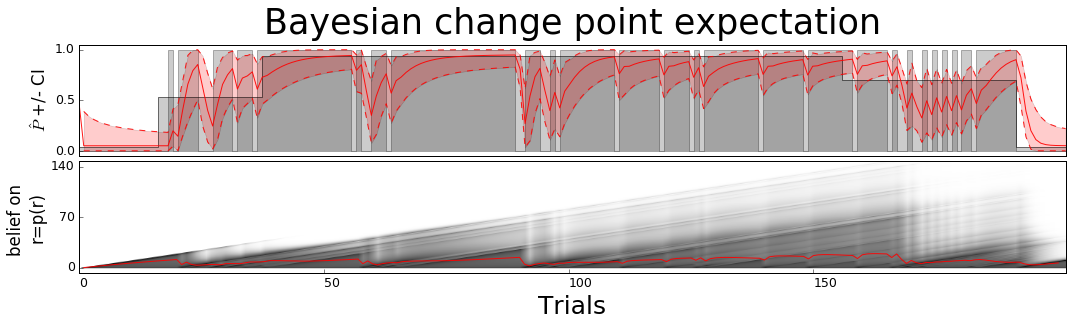

In [13]:
fig(p, block=2)

Block 2


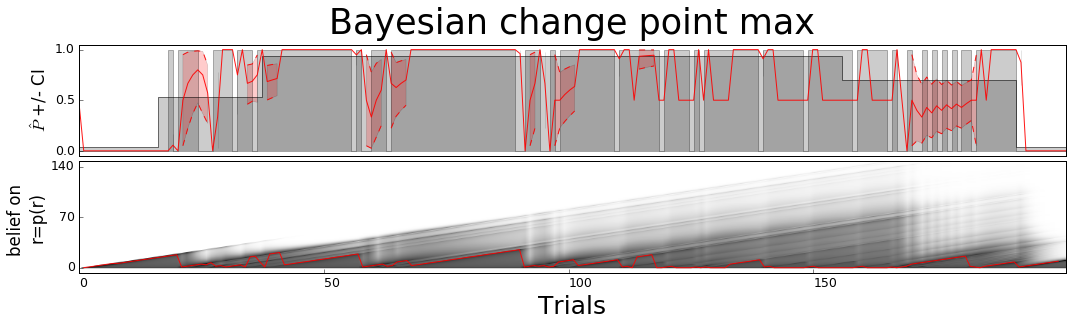

In [14]:
fig(p, block=2, mode='max')